* Variable	UM
* MP-10	ug/m3
* Dirección del viento	°Grados
* Velocidad del viento	km/h
* Temperatura Ambiente	°C
* Humedad relativa del aire	%
* Radiación Solar	cal/m2
* Pluviometría	mm


In [72]:
import lightgbm as ltb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
work_directory = "/home/edgar/hackamine"
data_directory = f"{work_directory}/data/E/E11"

In [11]:
# load data
meteorology_file = "Consulta_E11_DC_METEO_01082022_31082022.xlsx"
mp10_file = "Consulta_E11_DC_MP-10_01082022_31082022.xlsx"

meteorology_df = pd.read_excel(
    f"{data_directory}/{meteorology_file}",
    index_col="Id"
)
mp10_df = pd.read_excel(
    f"{data_directory}/{mp10_file}",
    index_col="Id"
)

Exploratory data analysis

In [12]:
meteorology_df.head()

,Fecha,Hora,DIR,VEL,TEMP,HR
Id,,,,,,
1,01/08/2022,00:00:00,202,0.3,10.4,18.0
2,01/08/2022,00:05:00,202,0.3,10.5,19.0
3,01/08/2022,00:10:00,202,0.3,10.2,18.0
4,01/08/2022,00:15:00,202,0.3,10.3,18.0
5,01/08/2022,00:20:00,202,0.3,10.3,18.0


In [13]:
mp10_df.head()

,Unnamed: 0,Fecha,Hora,MP_10
Id,,,,
1,0,01/08/2022,00:00:00,249.3
2,1,01/08/2022,00:05:00,298.8
3,2,01/08/2022,00:10:00,369.0
4,3,01/08/2022,00:15:00,544.5
5,4,01/08/2022,00:20:00,373.5


In [24]:
mp10_df.shape[0] == meteorology_df.shape[0]
print(mp10_df.shape)
# They have the same data

(8928, 5)


# Pollution

In [16]:
# convert date and time columns to numerical values to plot
# time series
meteorology_df["dateTime"] = pd.to_datetime(
    meteorology_df["Fecha"] + " " + meteorology_df["Hora"],
    format="%d/%m/%Y %H:%M:%S"
)
mp10_df["dateTime"] = pd.to_datetime(
    mp10_df["Fecha"] + " " + mp10_df["Hora"],
    format="%d/%m/%Y %H:%M:%S"
)

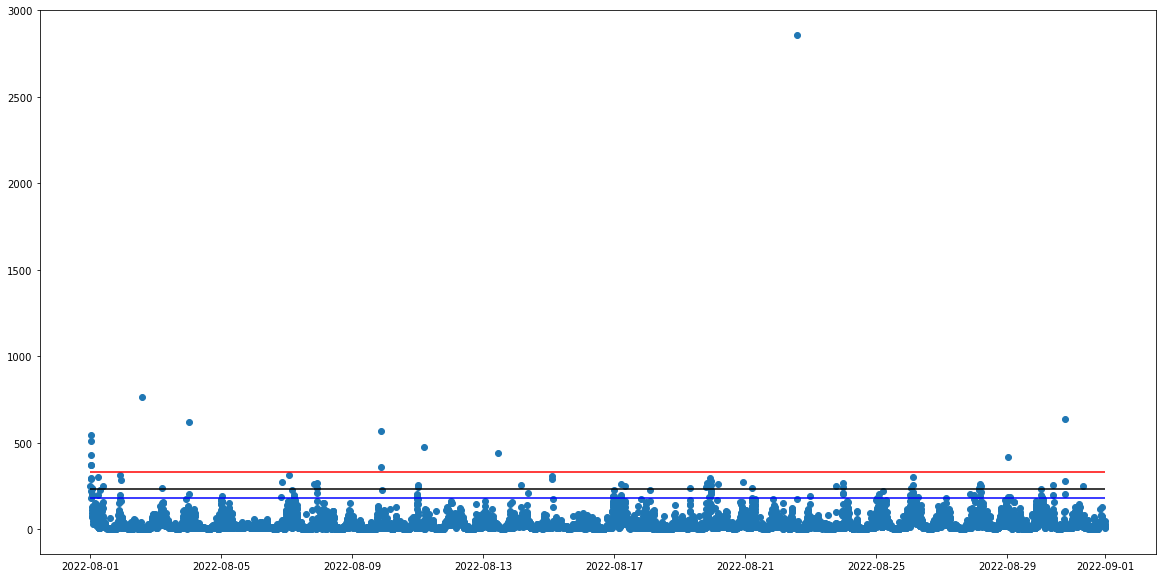

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(mp10_df["dateTime"], mp10_df["MP_10"])
ax.hlines(
    y=[180, 230, 330],
    color=["blue", "black","red"],
    xmin=mp10_df["dateTime"].min(),
    xmax=mp10_df["dateTime"].max(),
)

# mp10_df.groupby(mp10_df["dateTime"].dt.day)["MP_10"].plot(
#     ax=ax, kind="scatter"
# )

In [29]:
min_time, max_time = mp10_df["dateTime"].min(), mp10_df["dateTime"].max()
max_time - min_time

Timedelta('30 days 23:55:00')

Merge all data

In [30]:
meteorology_df.loc[mp10_df.index, "MP_10"] = mp10_df["MP_10"]

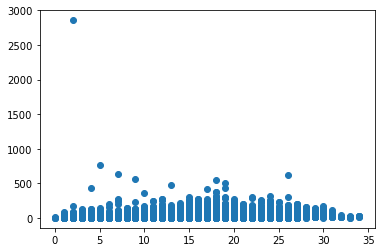

In [33]:
fig, ax = plt.subplots()
ax.scatter(meteorology_df["HR"], meteorology_df["MP_10"])

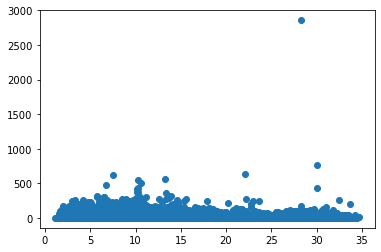

In [34]:
fig, ax = plt.subplots()
ax.scatter(meteorology_df["TEMP"], meteorology_df["MP_10"])

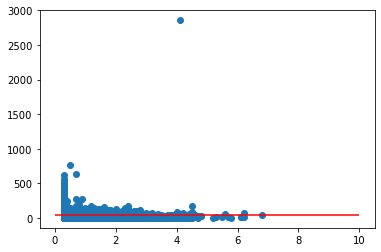

In [64]:
fig, ax = plt.subplots()
ax.scatter(meteorology_df["VEL"], meteorology_df["MP_10"])

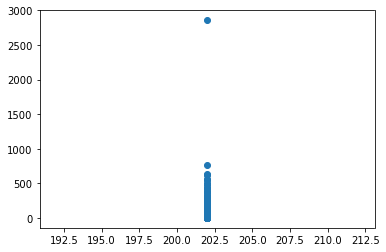

In [37]:
fig, ax = plt.subplots()
ax.scatter(meteorology_df["DIR"], meteorology_df["MP_10"])

In [39]:
meteorology_df.nunique()

Fecha         31
Hora         288
DIR            1
VEL           55
TEMP         336
HR            35
dateTime    8928
MP_10        284
dtype: int64

In [40]:
meteorology_df.describe()

,DIR,VEL,TEMP,HR,MP_10
count,8928.0,8928.000000,8928.000000,8928.000000,8928.000000
mean,202.0,0.597278,16.710293,11.577733,31.853528
std,0.0,0.814924,9.691156,7.470565,52.992598
min,202.0,0.300000,1.100000,0.000000,0.900000
25%,202.0,0.300000,7.500000,4.000000,7.200000
50%,202.0,0.300000,15.000000,12.000000,14.400000
75%,202.0,0.400000,26.600000,17.000000,37.800000
max,202.0,6.800000,34.700000,34.000000,2858.400000


In [63]:
time_delta = meteorology_df["dateTime"].diff().dt.total_seconds()/60
time_delta[1:10]

Id
2     5.0
3     5.0
4     5.0
5     5.0
6     5.0
7     5.0
8     5.0
9     5.0
10    5.0
Name: dateTime, dtype: float64

# Forecasting model (proof of concept)
Inspired in:
https://towardsdatascience.com/time-series-forecasting-with-machine-learning-b3072a5b44ba

In [67]:
meteorology_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 1 to 8928
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     8928 non-null   object        
 1   Hora      8928 non-null   object        
 2   DIR       8928 non-null   int64         
 3   VEL       8928 non-null   float64       
 4   TEMP      8928 non-null   float64       
 5   HR        8928 non-null   float64       
 6   dateTime  8928 non-null   datetime64[ns]
 7   MP_10     8928 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 885.8+ KB


In [70]:
# train and validation split
X = meteorology_df.loc[:, ["HR", "TEMP", "VEL"]].copy()
y = meteorology_df.loc[:, "MP_10"].copy()

In [80]:
split_fraction = 0.9
X_train, X_val = X[:int(split_fraction*X.shape[0])], X[int(split_fraction*X.shape[0]):]
y_train, y_val = y[:int(split_fraction*y.shape[0])], y[int(split_fraction*y.shape[0]):]

In [81]:
model = ltb.LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [82]:
predictions = model.predict(X_val)

In [83]:
# compute prediction error
error = np.abs(predictions - y_val)

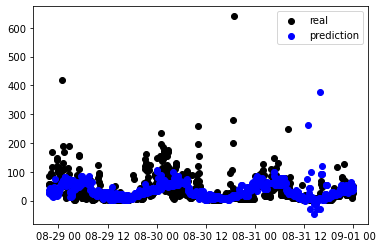

In [87]:
fig, ax = plt.subplots()
time = meteorology_df.loc[y_val.index, "dateTime"]
ax.scatter(time, y_val, color="black", label="real")
ax.scatter(time, pd.Series(predictions, index=y_val.index), color='blue', label="prediction")
ax.legend()

<AxesSubplot:xlabel='importance', ylabel='feature'>

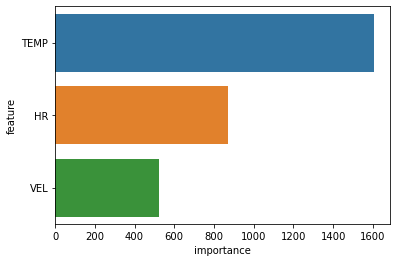

In [94]:
importance_df = pd.DataFrame({
    "feature": model.feature_name_,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
# ax.title.set("Feature importance")
sns.barplot(x=importance_df.importance, y=importance_df.feature, ax=ax, orient="h")

In [95]:
model.feature_importances_

array([ 870, 1605,  525], dtype=int32)